#### Name: SungChun Huang 
#### ID: 6280134

In [74]:
import numpy as np 
import pandas as pd 
import geopandas as gpd
from shapely.ops import unary_union
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import matplotlib.colors as mcolors
import matplotlib.patches as mpatches
from matplotlib.colors import ListedColormap

`Total runtime: ~ 00:00:33`

In [75]:
# Import the time module
import time

# Record the start time
start_time = time.time()
print("Notebook execution started at:", time.strftime("%Y-%m-%d %H:%M:%S", time.localtime(start_time)))

Notebook execution started at: 2024-07-15 11:56:34


# **Gerrymandering Electorial Manipulation** 


It's election time. One of the most common concern is gerry mandering whereby politician in power try to set the boundary for each district to given one's own party an advantage. (just google the word). In the simplest form, one can do this because the election is not a popular vote but an electoral vote. So one could win the election with out having the most number of popular votes; because you just need to win enough electors.

The typical trick is to make sure that for the electoral vote you lose you lose by a large amount, but for electoral vote you win you win by a very close margin. You can think about this as a budget game. There are finite people who would vote for you. And all the vote that happens in the district that you lose are 100% waste (Thailand try to fix this but messed this up real bad last time.)

In this problem you are given 500 areas with the corresponding number for red/blue vote. Your job is 

1) to group the area up in to 50 electoral districts where each electoral district consists of exactly 10 area.

2) Make sure red win as many electoral district as possible. Print something useful to show me that you have accomplish both.


Note: There are couple ways to do this. Any valid method is accepted. If you find that your algo is a bit hard to converge because you just plain number of distric red wins as cost function, you might want to consider smoothing out the cost function by noticing that for the one that we win we want to win it by as narrow as possible margin and/or when we lose we want to lose as much a s possible(to save the wasted vote). 

Note: In reallife there is a constraint that the area you group together has to be somewhat "adjacent". But we don't care about it in this case.

Note: This is also why you rarely see politician if your district is not a swing/undecided district.

Note: In Thailand, it is not stated explicitly that this kind of activity is illegal. (See Bangkok's Ratchtewi electoral district map for the upcoming election as an example.)

-------
#### Given Data

In [76]:
np.random.seed(777)
n_area = 500
blue = np.random.randn(n_area)*np.sqrt(1000)+1000
red = np.random.randn(n_area)*np.sqrt(970)+970

# red has 3% less vote
(np.sum(blue)-np.sum(red))/(np.sum(blue))

np.float64(0.027711511441615343)

-------
#### Generate 21 x 21 = 441 square grid 

In [77]:
# Set random seed for reproducibility
np.random.seed(777)

# Generate data
n_area = 441
grid_size = int(np.sqrt(n_area))
blue = np.random.randn(n_area) * np.sqrt(1000) + 1000
red = np.random.randn(n_area) * np.sqrt(970) + 970

# red has 3% less vote
red_disadvantage = (np.sum(blue) - np.sum(red)) / (np.sum(blue))
print(f"Red party disadvantage: {red_disadvantage:.3%}")

Red party disadvantage: 2.761%


-------
## Gerrymandering functions

In [78]:
def get_adjacent_indices(index):
    row, col = divmod(index, grid_size)
    adjacent = []
    for dr, dc in [(-1, -1), (-1, 0), (-1, 1), (0, -1), (0, 1), (1, -1), (1, 0), (1, 1)]:
        new_row, new_col = row + dr, col + dc
        if 0 <= new_row < grid_size and 0 <= new_col < grid_size:
            adjacent.append(new_row * grid_size + new_col)
    return adjacent

def count_red_wins(districts):
    return sum(np.sum(red[districts == i]) > np.sum(blue[districts == i]) for i in range(49))

def advanced_gerrymandering():
    blue_advantage = blue - red
    sorted_indices = np.argsort(-blue_advantage)
    
    districts = np.full(n_area, -1)
    
    # Pack: Create a few districts with high blue concentration
    num_packed_districts = 5
    for i in range(num_packed_districts):
        packed_areas = sorted_indices[i*9:(i+1)*9]
        districts[packed_areas] = i
    
    # Crack: Distribute some blue-leaning areas across multiple districts
    num_crack_districts = 10
    crack_areas = sorted_indices[num_packed_districts*9:(num_packed_districts+num_crack_districts)*9]
    for i, area in enumerate(crack_areas):
        districts[area] = num_packed_districts + (i % num_crack_districts)
    
    # Optimize remaining districts for red wins
    remaining_areas = [i for i in range(n_area) if districts[i] == -1]
    remaining_areas.sort(key=lambda x: red[x] - blue[x], reverse=True)
    
    for i, area in enumerate(remaining_areas):
        districts[area] = (num_packed_districts + num_crack_districts) + (i // 9)
    
    return districts

def iterative_optimization(districts, max_iterations=10000):
    current_score = count_red_wins(districts)
    
    for _ in range(max_iterations):
        # Randomly select two different districts
        district1, district2 = np.random.choice(49, 2, replace=False)
        
        # Randomly select an area from each district
        area1 = np.random.choice(np.where(districts == district1)[0])
        area2 = np.random.choice(np.where(districts == district2)[0])
        
        # Swap the areas
        districts[area1], districts[area2] = district2, district1
        
        new_score = count_red_wins(districts)
        
        if new_score > current_score:
            current_score = new_score
        else:
            # If no improvement, revert the swap
            districts[area1], districts[area2] = district1, district2
        
        # If red wins more than 25 districts, we can stop
        if current_score > 25:
            break
    
    return districts, current_score


------
### Results  

```
Total votes - Red: 428882, Blue: 441059

Popular vote - Red: 49.30%, Blue: 50.70%

Electoral districts won - Red: 18, Blue: 31

Winning areas - Red: 115, Blue: 326`


In [79]:
# Run advanced gerrymandering
initial_districts = advanced_gerrymandering()

# Run iterative optimization
optimized_districts, red_wins = iterative_optimization(initial_districts)

blue_wins = 49 - red_wins
total_red_votes = np.sum(red)
total_blue_votes = np.sum(blue)

print(f"Total votes - Red: {total_red_votes:.0f}, Blue: {total_blue_votes:.0f}")
print(f"Popular vote - Red: {total_red_votes/(total_red_votes+total_blue_votes):.2%}, Blue: {total_blue_votes/(total_red_votes+total_blue_votes):.2%}")
print(f"Electoral districts won - Red: {red_wins}, Blue: {blue_wins}")

# Calculate winning areas for each party
red_winning_areas = np.sum(red > blue)
blue_winning_areas = np.sum(blue > red)
print(f"Winning areas - Red: {red_winning_areas}, Blue: {blue_winning_areas}")

Total votes - Red: 428882, Blue: 441059
Popular vote - Red: 49.30%, Blue: 50.70%
Electoral districts won - Red: 18, Blue: 31
Winning areas - Red: 115, Blue: 326


---------
### Visualizations

- `Total votes - Red: 428882, Blue: 441059`
- `Popular vote - Red: 49.30%, Blue: 50.70%`
- `Electoral districts won - Red: 18, Blue: 31`
- `Winning areas - Red: 115, Blue: 326`

Total votes - Red: 428882, Blue: 441059
Popular vote - Red: 49.30%, Blue: 50.70%
Electoral districts won - Red: 18, Blue: 31
Winning areas - Red: 115, Blue: 326


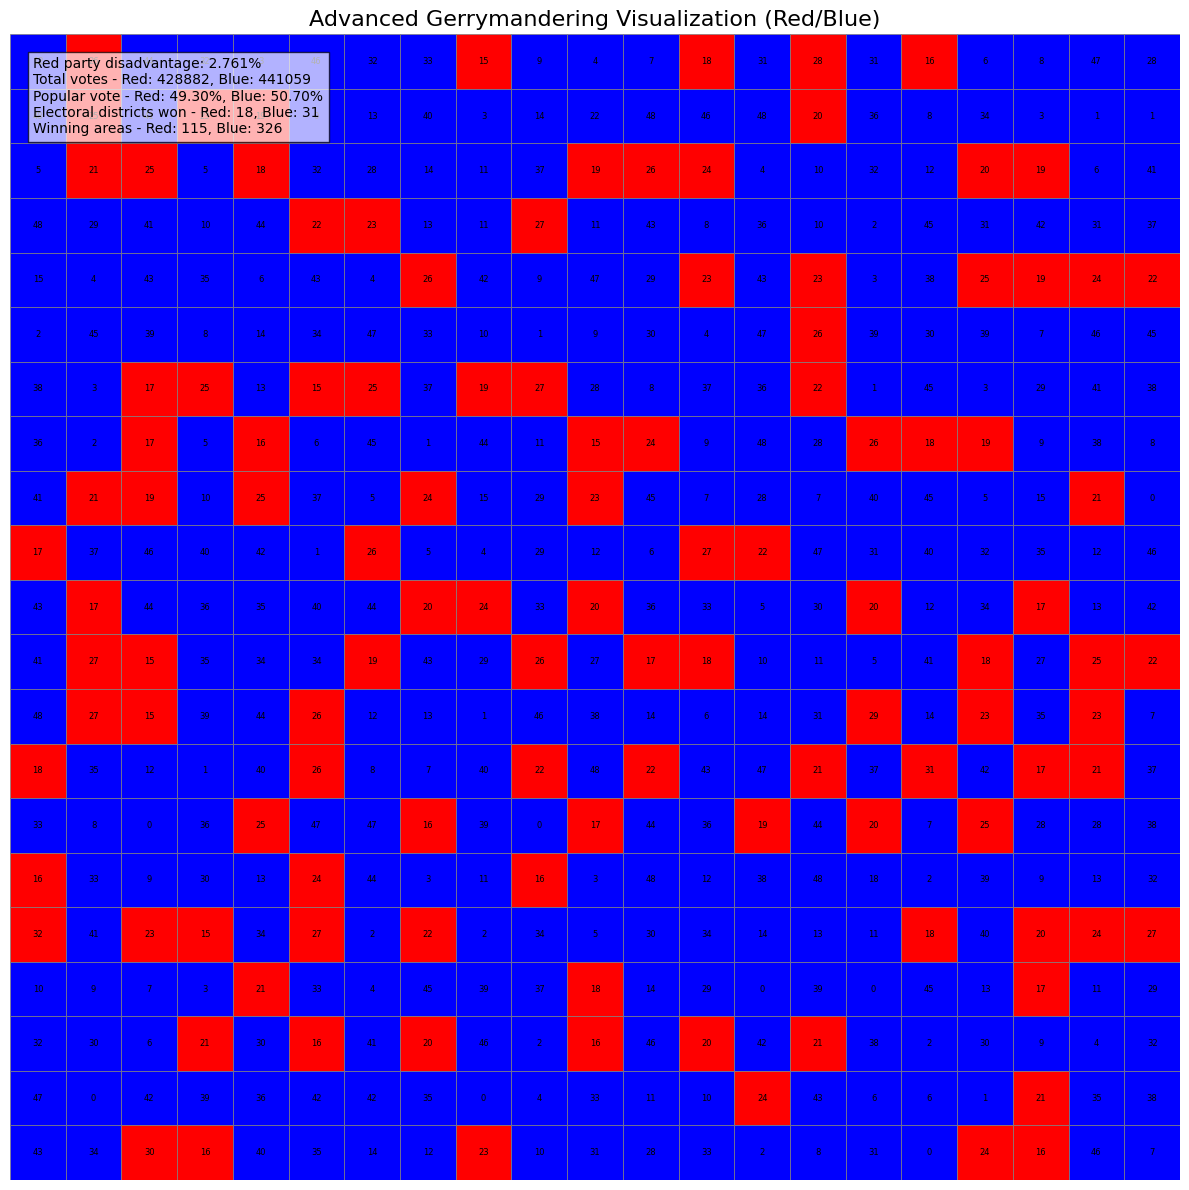

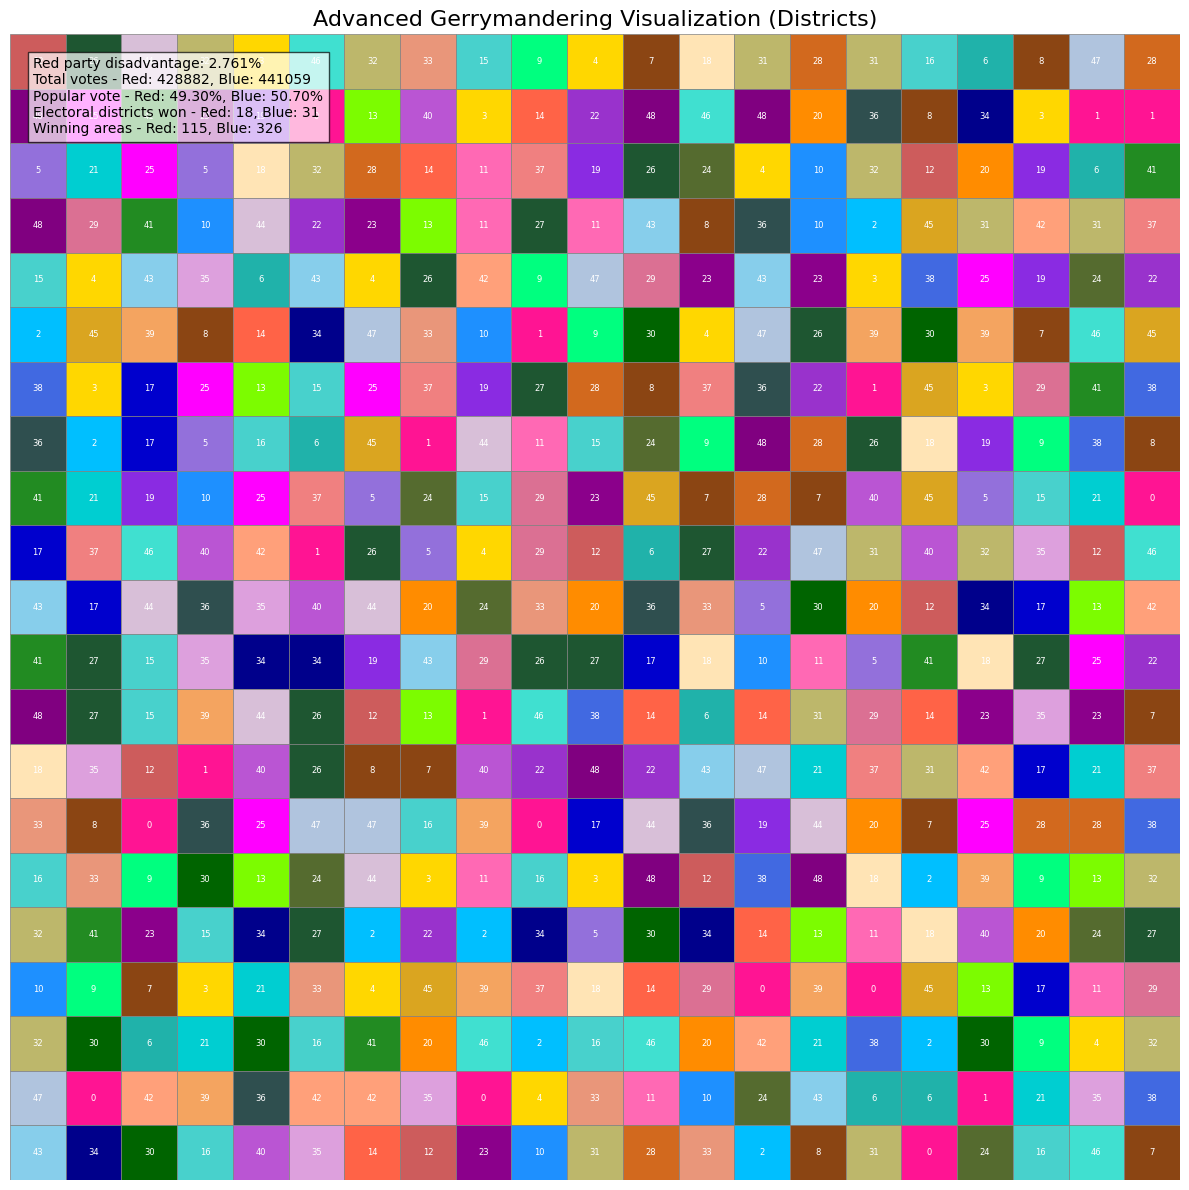

In [80]:
def visualize_red_blue(optimized_districts, red, blue, red_wins, blue_wins, total_red_votes, total_blue_votes, red_winning_areas, blue_winning_areas):
    plt.figure(figsize=(12, 12))

    # Create a new axes with a white background
    ax = plt.gca()
    ax.set_facecolor('white')

    # Draw rectangles for each area
    for i in range(grid_size):
        for j in range(grid_size):
            index = i * grid_size + j
            color = 'red' if red[index] > blue[index] else 'blue'
            rect = patches.Rectangle((j, i), 1, 1, facecolor=color, edgecolor='gray', linewidth=0.5)
            ax.add_patch(rect)
            
            # Add district number to each area
            plt.text(j+0.5, i+0.5, str(optimized_districts[index]), ha='center', va='center', fontsize=6)

    plt.title('Advanced Gerrymandering Visualization (Red/Blue)', fontsize=16)
    plt.xlim(0, grid_size)
    plt.ylim(0, grid_size)
    plt.gca().invert_yaxis()  # Invert y-axis to match the original grid orientation
    plt.axis('off')

    # Add text with results
    plt.text(0.02, 0.98, f"Red party disadvantage: {red_disadvantage:.3%}\n"
                         f"Total votes - Red: {total_red_votes:.0f}, Blue: {total_blue_votes:.0f}\n"
                         f"Popular vote - Red: {total_red_votes/(total_red_votes+total_blue_votes):.2%}, Blue: {total_blue_votes/(total_red_votes+total_blue_votes):.2%}\n"
                         f"Electoral districts won - Red: {red_wins}, Blue: {blue_wins}\n"
                         f"Winning areas - Red: {red_winning_areas}, Blue: {blue_winning_areas}",
             transform=plt.gca().transAxes, verticalalignment='top',
             fontsize=10, bbox=dict(facecolor='white', alpha=0.7))

    plt.tight_layout()
    plt.show()

def visualize_districts(optimized_districts, red_wins, blue_wins, total_red_votes, total_blue_votes, red_winning_areas, blue_winning_areas):
    plt.figure(figsize=(12, 12))

    # Create a new axes with a white background
    ax = plt.gca()
    ax.set_facecolor('white')

    # Create a colormap with 49 distinct colors
    colors = [
    '#FF1493', '#00BFFF', '#32CD32', '#FFD700', '#FF4500', '#9370DB', '#20B2AA', # 7
    '#8B4513', '#4B0082', '#00FF7F', '#1E90FF', '#FF69B4', '#CD5C5C', '#7CFC00', # 14
    '#FF6347', '#48D1CC', '#C71585', '#0000CD', '#FFE4B5', '#8A2BE2', '#FF8C00', # 21
    '#00CED1', '#9932CC', '#8B008B', '#556B2F', '#FF00FF', '#1E5631', '#191970', # 28
    '#D2691E', '#DB7093', '#006400', '#BDB76B', '#8B0000', '#E9967A', '#00008B', # 35
    '#DDA0DD', '#2F4F4F', '#F08080', '#4169E1', '#F4A460', '#BA55D3', '#228B22', # 42
    '#FFA07A', '#87CEEB', '#D8BFD8', '#DAA520', '#40E0D0', '#B0C4DE', '#800080', # 49
    ]
    cmap = ListedColormap(colors)
    district_colors = [cmap(i/49) for i in range(49)]

    # Draw rectangles for each area
    for i in range(grid_size):
        for j in range(grid_size):
            index = i * grid_size + j
            district = optimized_districts[index]
            color = district_colors[district]
            rect = patches.Rectangle((j, i), 1, 1, facecolor=color, edgecolor='gray', linewidth=0.5)
            ax.add_patch(rect)
            
            # Add district number to each area
            plt.text(j+0.5, i+0.5, str(district), ha='center', va='center', fontsize=6, color='white')

    plt.title('Advanced Gerrymandering Visualization (Districts)', fontsize=16)
    plt.xlim(0, grid_size)
    plt.ylim(0, grid_size)
    plt.gca().invert_yaxis()  # Invert y-axis to match the original grid orientation
    plt.axis('off')

    # Add text with results
    plt.text(0.02, 0.98, f"Red party disadvantage: {red_disadvantage:.3%}\n"
                         f"Total votes - Red: {total_red_votes:.0f}, Blue: {total_blue_votes:.0f}\n"
                         f"Popular vote - Red: {total_red_votes/(total_red_votes+total_blue_votes):.2%}, Blue: {total_blue_votes/(total_red_votes+total_blue_votes):.2%}\n"
                         f"Electoral districts won - Red: {red_wins}, Blue: {blue_wins}\n"
                         f"Winning areas - Red: {red_winning_areas}, Blue: {blue_winning_areas}",
             transform=plt.gca().transAxes, verticalalignment='top',
             fontsize=10, bbox=dict(facecolor='white', alpha=0.7))

    plt.tight_layout()
    plt.show()

# Run advanced gerrymandering
initial_districts = advanced_gerrymandering()

# Run iterative optimization
optimized_districts, red_wins = iterative_optimization(initial_districts)

blue_wins = 49 - red_wins
total_red_votes = np.sum(red)
total_blue_votes = np.sum(blue)

print(f"Total votes - Red: {total_red_votes:.0f}, Blue: {total_blue_votes:.0f}")
print(f"Popular vote - Red: {total_red_votes/(total_red_votes+total_blue_votes):.2%}, Blue: {total_blue_votes/(total_red_votes+total_blue_votes):.2%}")
print(f"Electoral districts won - Red: {red_wins}, Blue: {blue_wins}")

# Calculate winning areas for each party
red_winning_areas = np.sum(red > blue)
blue_winning_areas = np.sum(blue > red)
print(f"Winning areas - Red: {red_winning_areas}, Blue: {blue_winning_areas}")

# Create both visualizations
visualize_red_blue(optimized_districts, red, blue, red_wins, blue_wins, total_red_votes, total_blue_votes, red_winning_areas, blue_winning_areas)
visualize_districts(optimized_districts, red_wins, blue_wins, total_red_votes, total_blue_votes, red_winning_areas, blue_winning_areas)

-------
#### Analysis on maximum disadvantage red can tolerate that would garentee a win.

- `Maximum disadvantage red can tolerate: 1.20%`

In [81]:
# Set random seed for reproducibility
np.random.seed(777)

# Generate data
n_area = 441
grid_size = int(np.sqrt(n_area))
blue = np.random.randn(n_area) * np.sqrt(1000) + 1000


# Iterate through different levels of disadvantage
results = []
start_mean = 1020  # Start with an advantage for red
end_mean = 980  # End with a significant disadvantage for red
step = -1  # Decrease the mean by 1 in each iteration

for red_mean in range(start_mean, end_mean-1, step):
    red = np.random.randn(n_area) * np.sqrt(970) + red_mean
    
    red_disadvantage = (np.sum(blue) - np.sum(red)) / (np.sum(blue))
    
    initial_districts = advanced_gerrymandering()
    optimized_districts, red_wins = iterative_optimization(initial_districts)
    
    blue_wins = 49 - red_wins
    total_red_votes = np.sum(red)
    total_blue_votes = np.sum(blue)
    red_vote_share = total_red_votes / (total_red_votes + total_blue_votes)
    
    results.append({
        'red_mean': red_mean,
        'disadvantage': red_disadvantage,
        'red_vote_share': red_vote_share,
        'red_wins': red_wins,
        'blue_wins': blue_wins
    })
    
    # Stop if red loses the election
    if red_wins <= 25:
        break

# Print results
print("Analysis of Red's Disadvantage Tolerance:")
print("Red Mean | Disadvantage | Red Vote Share | Red Districts | Blue Districts")
print("-" * 75)
for result in results:
    print(f"{result['red_mean']:.2f} | {result['disadvantage']:+.2%} | {result['red_vote_share']:.2%} | {result['red_wins']:13d} | {result['blue_wins']:14d}")

# Find the maximum disadvantage where red still wins
max_disadvantage = max(r['disadvantage'] for r in results if r['red_wins'] > 25)
print(f"\nMaximum disadvantage red can tolerate: {max_disadvantage:.2%}")

Analysis of Red's Disadvantage Tolerance:
Red Mean | Disadvantage | Red Vote Share | Red Districts | Blue Districts
---------------------------------------------------------------------------
1020.00 | -2.24% | 50.55% |            34 |             15
1019.00 | -1.92% | 50.48% |            32 |             17
1018.00 | -1.77% | 50.44% |            32 |             17
1017.00 | -1.65% | 50.41% |            32 |             17
1016.00 | -1.44% | 50.36% |            32 |             17
1015.00 | -1.49% | 50.37% |            30 |             19
1014.00 | -1.29% | 50.32% |            30 |             19
1013.00 | -1.22% | 50.30% |            29 |             20
1012.00 | -1.12% | 50.28% |            30 |             19
1011.00 | -1.36% | 50.34% |            32 |             17
1010.00 | -1.06% | 50.26% |            29 |             20
1009.00 | -0.89% | 50.22% |            27 |             22
1008.00 | -0.89% | 50.22% |            29 |             20
1007.00 | -0.65% | 50.16% |            27

------------
------------
------------
------------
------------
# **Application in real life data: North Carolina 2020 presidential election data**

I chose **NORTH CAROLINA** because i was inspired by this [video](https://www.youtube.com/watch?v=KpamjJtXqFI&t=124s)

#### Types of data required 

1.	**Geographical Data**: ✅
- Precinct Boundaries: The geographical boundaries of voting precincts or districts.
- Census Data: Population data from the census, which can be used to understand the distribution of different demographic groups.
2.	**Election Results**: ✅
- Historical Election Results: Past election results for various races (e.g., presidential, congressional, state legislative).
- Turnout Data: Voter turnout data to understand the proportion of the population that votes.

#### Sources of Data:
- **Presidential Election Result**:
    -   MIT Election Data + Science Lab [U.S. President Precinct-Level Returns 2020](https://electionlab.mit.edu/data#data)
- **Statemap**:
    -   United States Census [2020 Tiger/line shapefiles](https://www.census.gov/cgi-bin/geo/shapefiles/index.php?year=2020&layergroup=Counties+%28and+equivalent%29)
- **NOTE:** `north_caroliona.shp` Data was handled and merged into a single `.shp` file prior for simplicity.




### Import `.csv` and `.shp` file

In [82]:
# Import Data
north_carolina = gpd.read_file('/Users/chromatrical/SCHOOL/TERM #5.2/NumCom/Final Project/Data/Cleaned/North_Carolina_Geo_Data.shp')

print(north_carolina.shape)
print(north_carolina.columns)
print()
print(north_carolina.dtypes)
north_carolina.head(3)

(100, 12)
Index(['GEOID', 'NAME', 'county_nam', 'DEMOCRAT', 'REPUBLICAN', 'LIBERTARIA',
       'GREEN', 'CONSTITUTI', 'candidate', 'mode', 'precinct', 'geometry'],
      dtype='object')

GEOID           object
NAME            object
county_nam      object
DEMOCRAT       float64
REPUBLICAN     float64
LIBERTARIA     float64
GREEN          float64
CONSTITUTI     float64
candidate       object
mode            object
precinct         int64
geometry      geometry
dtype: object


,GEOID,NAME,county_nam,DEMOCRAT,REPUBLICAN,LIBERTARIA,GREEN,CONSTITUTI,candidate,mode,precinct,geometry
0,37037,Chatham,Chatham,26787.0,21186.0,366.0,90.0,60.0,"JO JORGENSEN, JOSEPH R BIDEN, DONALD J TRUMP, ...","ABSENTEE BY MAIL, ONE STOP, ELECTION DAY, PROV...",18,"POLYGON ((-79.5447 35.77054, -79.54466 35.7717..."
1,37001,Alamance,Alamance,38825.0,46056.0,686.0,223.0,151.0,"JO JORGENSEN, JOSEPH R BIDEN, DONALD J TRUMP, ...","ABSENTEE BY MAIL, ONE STOP, ELECTION DAY, PROV...",39,"POLYGON ((-79.53941 36.04574, -79.53941 36.045..."
2,37057,Davidson,Davidson,22636.0,64658.0,703.0,187.0,189.0,"JO JORGENSEN, JOSEPH R BIDEN, DONALD J TRUMP, ...","ABSENTEE BY MAIL, ONE STOP, ELECTION DAY, PROV...",51,"POLYGON ((-80.19918 36.0268, -80.19883 36.0268..."


Total number of votes for DEMOCRAT: 2684292.0
Percentage of votes for DEMOCRAT: 48.70%
--------------------------------------------
Total number of votes for REPUBLICAN: 2758773.0
Percentage of votes for REPUBLICAN: 50.05%
--------------------------------------------
Total number of votes for LIBERTARIA: 48678.0
Percentage of votes for LIBERTARIA: 0.88%
--------------------------------------------
Total number of votes for GREEN: 12195.0
Percentage of votes for GREEN: 0.22%
--------------------------------------------
Total number of votes for CONSTITUTI: 7549.0
Percentage of votes for CONSTITUTI: 0.14%
--------------------------------------------
Percentage difference between DEMOCRAT and REPUBLICAN: -1.35%
DEMOCRATS have -74481.0 more votes than REPUBLICANS.


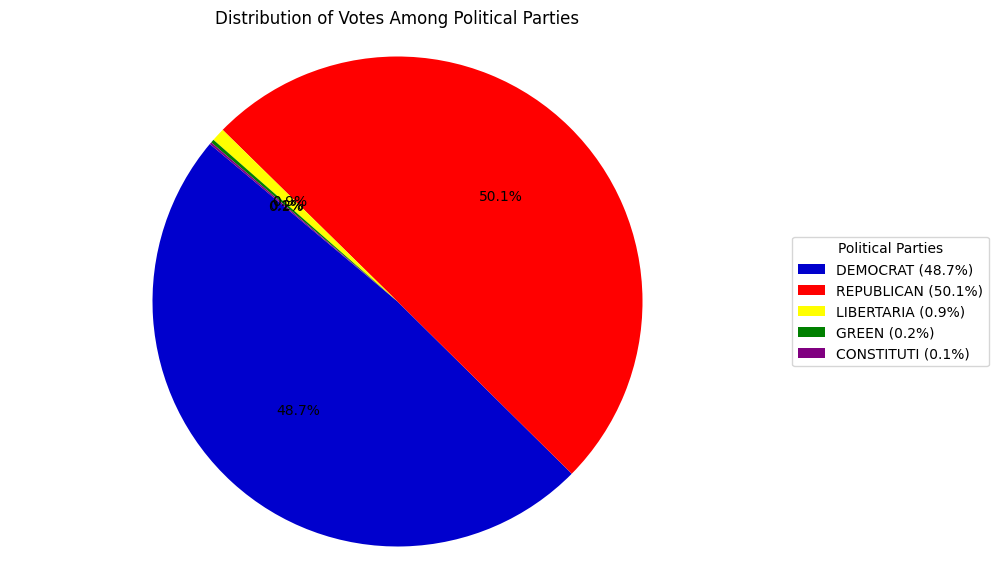

In [83]:
# Extract only the columns containing vote counts
vote_columns = ['DEMOCRAT', 'REPUBLICAN', 'LIBERTARIA', 'GREEN', 'CONSTITUTI']
vote_data = north_carolina[vote_columns]

# Calculate the total votes for each party
party_totals = vote_data.sum()

# Calculate the total number of votes
total_votes = party_totals.sum()

# Calculate the percentage of votes for each party
party_percentages = (party_totals / total_votes) * 100

# Print the total number of votes and percentage for each party
for party in party_totals.index:
    print(f"Total number of votes for {party}: {party_totals[party]}")
    print(f"Percentage of votes for {party}: {party_percentages[party]:.2f}%")
    print("--------------------------------------------")

# Calculate and print the percentage difference between Democrats and Republicans
dem_votes = party_totals['DEMOCRAT']
rep_votes = party_totals['REPUBLICAN']
percentage_difference = (dem_votes - rep_votes) / total_votes * 100

print(f"Percentage difference between DEMOCRAT and REPUBLICAN: {percentage_difference:.2f}%")
print(f"DEMOCRATS have {party_totals['DEMOCRAT'] - party_totals['REPUBLICAN']} more votes than REPUBLICANS.")

# Define colors for each party
colors = {
    'DEMOCRAT': 'mediumblue',
    'REPUBLICAN': 'red',
    'LIBERTARIA': 'yellow',
    'GREEN': 'green',
    'CONSTITUTI': 'purple',
}

# Create labels with percentages for the legend
legend_labels = [f"{party} ({percentage:.1f}%)" for party, percentage in party_percentages.items()]
fig, ax = plt.subplots(figsize=(10, 7))
wedges, texts, autotexts = ax.pie(party_totals, labels=None, colors=[colors[party] for party in party_totals.index], autopct='%1.1f%%', startangle=140)
ax.legend(wedges, legend_labels, title="Political Parties", loc="center left", bbox_to_anchor=(1, 0, 0.5, 1))

plt.title('Distribution of Votes Among Political Parties')
plt.axis('equal') 
plt.show()

Number of districts won by each party:
REPUBLICAN: 75
DEMOCRAT: 25


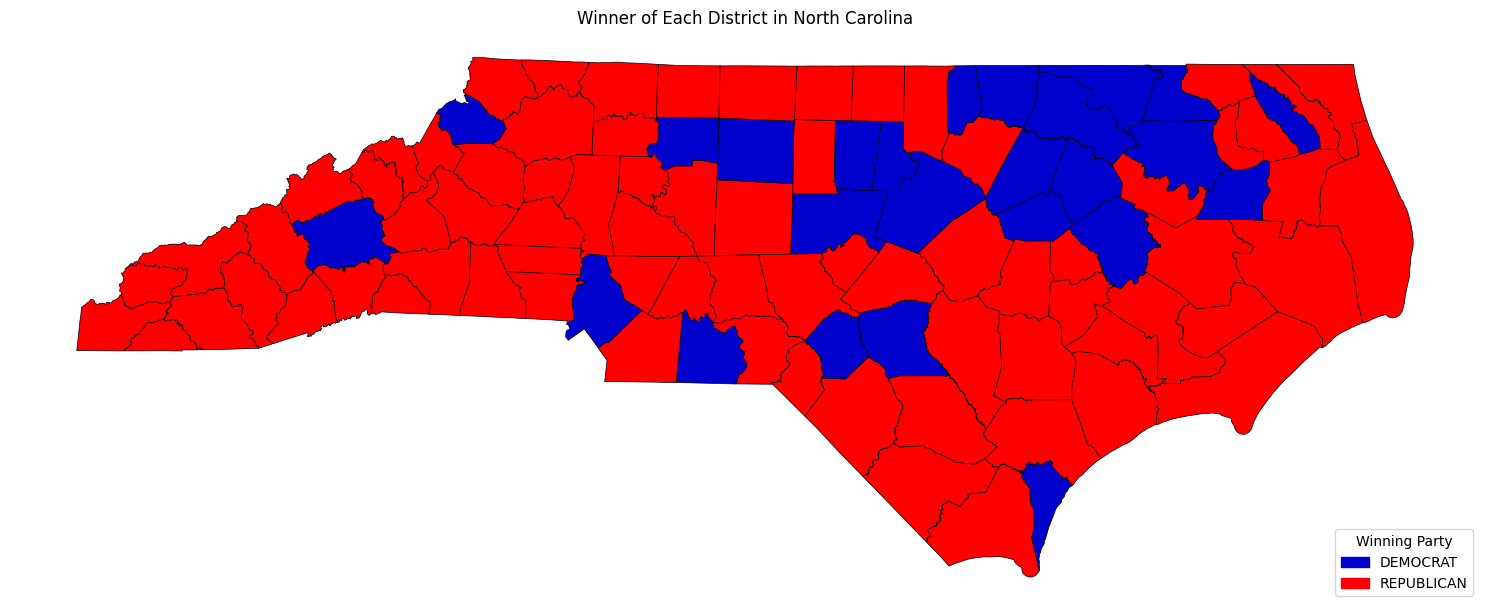

In [84]:
# Determine the winner of each district
def get_winner(row):
    # Get the columns that represent parties
    party_columns = [col for col in row.index if col in ['DEMOCRAT', 'REPUBLICAN', 'LIBERTARIA', 'CONSTITUTI', 'GREEN']]
    
    # Find the party with the maximum votes
    winner = max(party_columns, key=lambda party: row[party])
    return winner

# Apply the function to determine the winner for each row
north_carolina['winner'] = north_carolina.apply(get_winner, axis=1)

# Count the number of districts won by each party
district_wins = north_carolina['winner'].value_counts()

# Print the results
print("Number of districts won by each party:")
for party, count in district_wins.items():
    print(f"{party}: {count}")

# Define the color map for the winners
colors = {'DEMOCRAT': 'mediumblue', 
          'REPUBLICAN': 'red', 
          'LIBERTARIAN': 'yellow', 
          'CONSTITUTION': 'purple', 
          'GREEN': 'green'}

# Create a custom colormap based on the parties present in the data
present_parties = north_carolina['winner'].unique()
color_map = mcolors.ListedColormap([colors[party] for party in present_parties])

# Plot the map
fig, ax = plt.subplots(figsize=(15, 10))
north_carolina.plot(column='winner', 
                    cmap=color_map,
                    edgecolor='black', 
                    linewidth=0.5,
                    legend=True, 
                    ax=ax)

# Create a custom legend
legend_patches = [mpatches.Patch(color=colors[party], label=party) for party in present_parties]
plt.legend(handles=legend_patches, loc='lower right', title='Winning Party')
plt.title('Winner of Each District in North Carolina')
plt.axis('off')  # Turn off the axis
plt.tight_layout()
plt.show()

---------------
## **Application of Gerrymandering from previous homework.**
- Conditions 
    - `DEMOCRATS have 74481 less votes than REPUBLICANS.` 
    - `DEMOCRATs have 1.35% less votes than REPUBLICANS.`
- Therefore, the rest of the project would be working towards trying to help **DEMOCRATS** win the election with LESSER total votes.
- **The number of desired districts can be adjusted accordingly by setting: `n_districts` below**

In [141]:
# Set the target number of district we want to create 
n_districts = 100

# This part can be adjusted according to the number of districts we want to create,
# However for appraoch #1 and #2, it would not work if exceeds 100 districts

--------
### **FUNCTIONS**

In [142]:
# Function to determine the winner of each district
def get_winner(row):
    party_columns = ['DEMOCRAT', 'REPUBLICAN', 'LIBERTARIA', 'CONSTITUTI', 'GREEN']
    return max(party_columns, key=lambda party: row[party])

# Count the number of districts won by Democrats 
def count_democrat_wins(districts, democrats, republicans): 
    return sum(np.sum(democrats[districts == i]) > np.sum(republicans[districts == i]) for i in np.unique(districts))

### GerryMandering Function <used by appraoch #1 and #2>

**Explaination:** 

The Function tries to assign areas to a specific number of districts that optimizes the distribution base on the advantage of the target beneficiaries over the detractors. 


In [143]:
# advanced_gerrymandering function <Winning Appraoch #2> 

def advanced_gerrymandering(beneficiaries, detractors, n_districts):
    # calculates the advantage of a given party over the other party in an area
    blue_advantage = beneficiaries - detractors
        # positive value == beneficary's advantage
        # negative value == detractor's advantage
        
    # sorts in descending order of the area base on `leading` advantages, 
    # and returns base on responding index -> `np.argsort()`.
    sorted_indices = np.argsort(-blue_advantage)
    
    # calculate the total number of areas to be assigned to the beneficaries.
    n_area = len(beneficiaries)
    
    # creates an array with length `n_area` and set all value to `-1` as marker as unassigned
    districts = np.full(n_area, -1)
    
    # calculate the number of areas to be allocated to each district
    areas_per_district = n_area // n_districts

    for i in range(n_districts):
        start = i * areas_per_district    
        if i < n_districts - 1: 
            # If i is less than n_districts - 1, 
            # the end index is calculated as start + areas_per_district.
            end = start + areas_per_district
        else:
            # Otherwise, for the last district (i == n_districts - 1), 
            # the end index is set to n_area to ensure all remaining areas are included.
            end = n_area
        districts[sorted_indices[start:end]] = i
        # The areas from start to end (based on sorted_indices) 
        # are assigned to the current district i.
    
    return districts

########################################################################################
# # advanced_gerrymandering function <Losing Appraoch #1> 

# def advanced_gerrymandering(beneficiaries, detractors, n_districts):
#     blue_advantage = beneficiaries - detractors
#     sorted_indices = np.argsort(-blue_advantage)
    
#     n_area = len(beneficiaries)
#     districts = np.full(n_area, -1)
    
#     # Pack: Create a few districts with high beneficiaries concentration
#     num_packed_districts = int(n_districts * 0.1)  # 10% packed
#     for i in range(num_packed_districts):
#         packed_areas = sorted_indices[i*10:(i+1)*10]
#         districts[packed_areas] = i
    
#     # Crack: Distribute some beneficiaries-leaning areas across multiple districts
#     num_crack_districts = int(n_districts * 0.2)  # 20% cracked
#     crack_areas = sorted_indices[num_packed_districts*10:(num_packed_districts+num_crack_districts)*10]
#     for i, area in enumerate(crack_areas):
#         districts[area] = num_packed_districts + (i % num_crack_districts)
    
#     # Optimize remaining districts for detractors wins
#     remaining_areas = [i for i in range(n_area) if districts[i] == -1]
#     remaining_areas.sort(key=lambda x: detractors[x] - beneficiaries[x], reverse=True)
    
#     for i, area in enumerate(remaining_areas):
#         districts[area] = (num_packed_districts + num_crack_districts) + (i // 10)
    
#     return districts

### Optimization Function 
**Explaination:** Using a area swapping appraoch to maximize number of districts won by Democrats. The function terminates after target party (Democrats) won more than half of the districts to optimize efficiency. 

The function utilizes **Local Search Heuristics** that starts with an intial solution `count_democrat_wins` then make small local adjustments *SWAPS* to improve the output. 


In [144]:
# optimization function <appraoch #1>

def iterative_optimization(districts, democrats, republicans, max_iterations=10000):
    # current_score: The number of districts won by Democrats after optimization.
    current_score = count_democrat_wins(districts, democrats, republicans)
    
    # Each iteration attempts to improve the districting.
    for _ in range(max_iterations):
        
        # Randomly select two different districts from the current set of unique districts. 
        district1, district2 = np.random.choice(np.unique(districts), 2, replace=False)
            # np.unique(districts) returns the unique district labels.
            
        # Randomly select an area from each district
        area1 = np.random.choice(np.where(districts == district1)[0])
        area2 = np.random.choice(np.where(districts == district2)[0])
        
        # Swap the areas
        districts[area1], districts[area2] = district2, district1
        
        # Re-evaluate the number of districts won by Democrats
        new_score = count_democrat_wins(districts, democrats, republicans)
        
        if new_score > current_score:
            current_score = new_score
        else:
            # If no improvement, revert the swap
            districts[area1], districts[area2] = district1, district2
        
        # If democrats wins more than half of the districts, we can stop
        if current_score > len(np.unique(districts)) // 2:
            break
    
    return districts, current_score

### Re-districting Function (for approach #3)

**Explaination:** this is a helper function that reconfigure the boundaries of districts by *merging* them into a unified shape. unfortunately breaking down the boundaries are part of the limitation of the data. 

In [145]:
# Function to redraw district boundaries
def redraw_districts(gdf, new_districts):
    new_districts_list = []
    for district in range(n_districts):
        # Merge all areas assigned to this district
        district_areas = gdf[new_districts == district]
        if not district_areas.empty:
            merged_geometry = unary_union(district_areas.geometry)
            new_districts_list.append({'district': district, 
                                       'geometry': merged_geometry})
    
    new_gdf = gpd.GeoDataFrame(new_districts_list, crs=gdf.crs)
    return new_gdf

########################################################################################
# # -------------------- ERROR APPROACH --------------------
# # Function to redraw district boundaries
# def redraw_districts(gdf, new_districts):
#     new_gdf = gpd.GeoDataFrame(columns=['district', 'geometry'])
#     for district in range(n_districts):
#         # Merge all areas assigned to this district
#         district_areas = gdf[new_districts == district]
#         if not district_areas.empty:
#             merged_geometry = unary_union(district_areas.geometry)
#             new_gdf = new_gdf.append({'district': district, 
#                                       'geometry': merged_geometry},
#                                       ignore_index=True) 
#
#     return new_gdf

--------
## Approach #1 

**Explaination:** 

In [146]:
# Extract vote counts for each party
vote_columns = ['DEMOCRAT', 'REPUBLICAN', 'LIBERTARIA', 'GREEN', 'CONSTITUTI']
vote_data = north_carolina[vote_columns]
party_totals = vote_data.sum()

# Assume REPUBLICAN and DEMOCRAT are Republicans and Democrats respectively
Republicans = vote_data['REPUBLICAN'].values
Democrats = vote_data['DEMOCRAT'].values

# Run advanced gerrymandering
initial_districts = advanced_gerrymandering(Democrats, Republicans, n_districts)

# Run iterative optimization
optimized_districts, Democrat_wins = iterative_optimization(initial_districts, Republicans, Democrats)

# Calculate Democrats wins
Republican_wins = n_districts - Democrat_wins

print(f"Electoral districts won - Democrats: {Democrat_wins}, Republicans: {Republican_wins}")

# Assign the optimized districts to the GeoDataFrame
north_carolina['new_district'] = optimized_districts

Electoral districts won - Democrats: 75, Republicans: 25


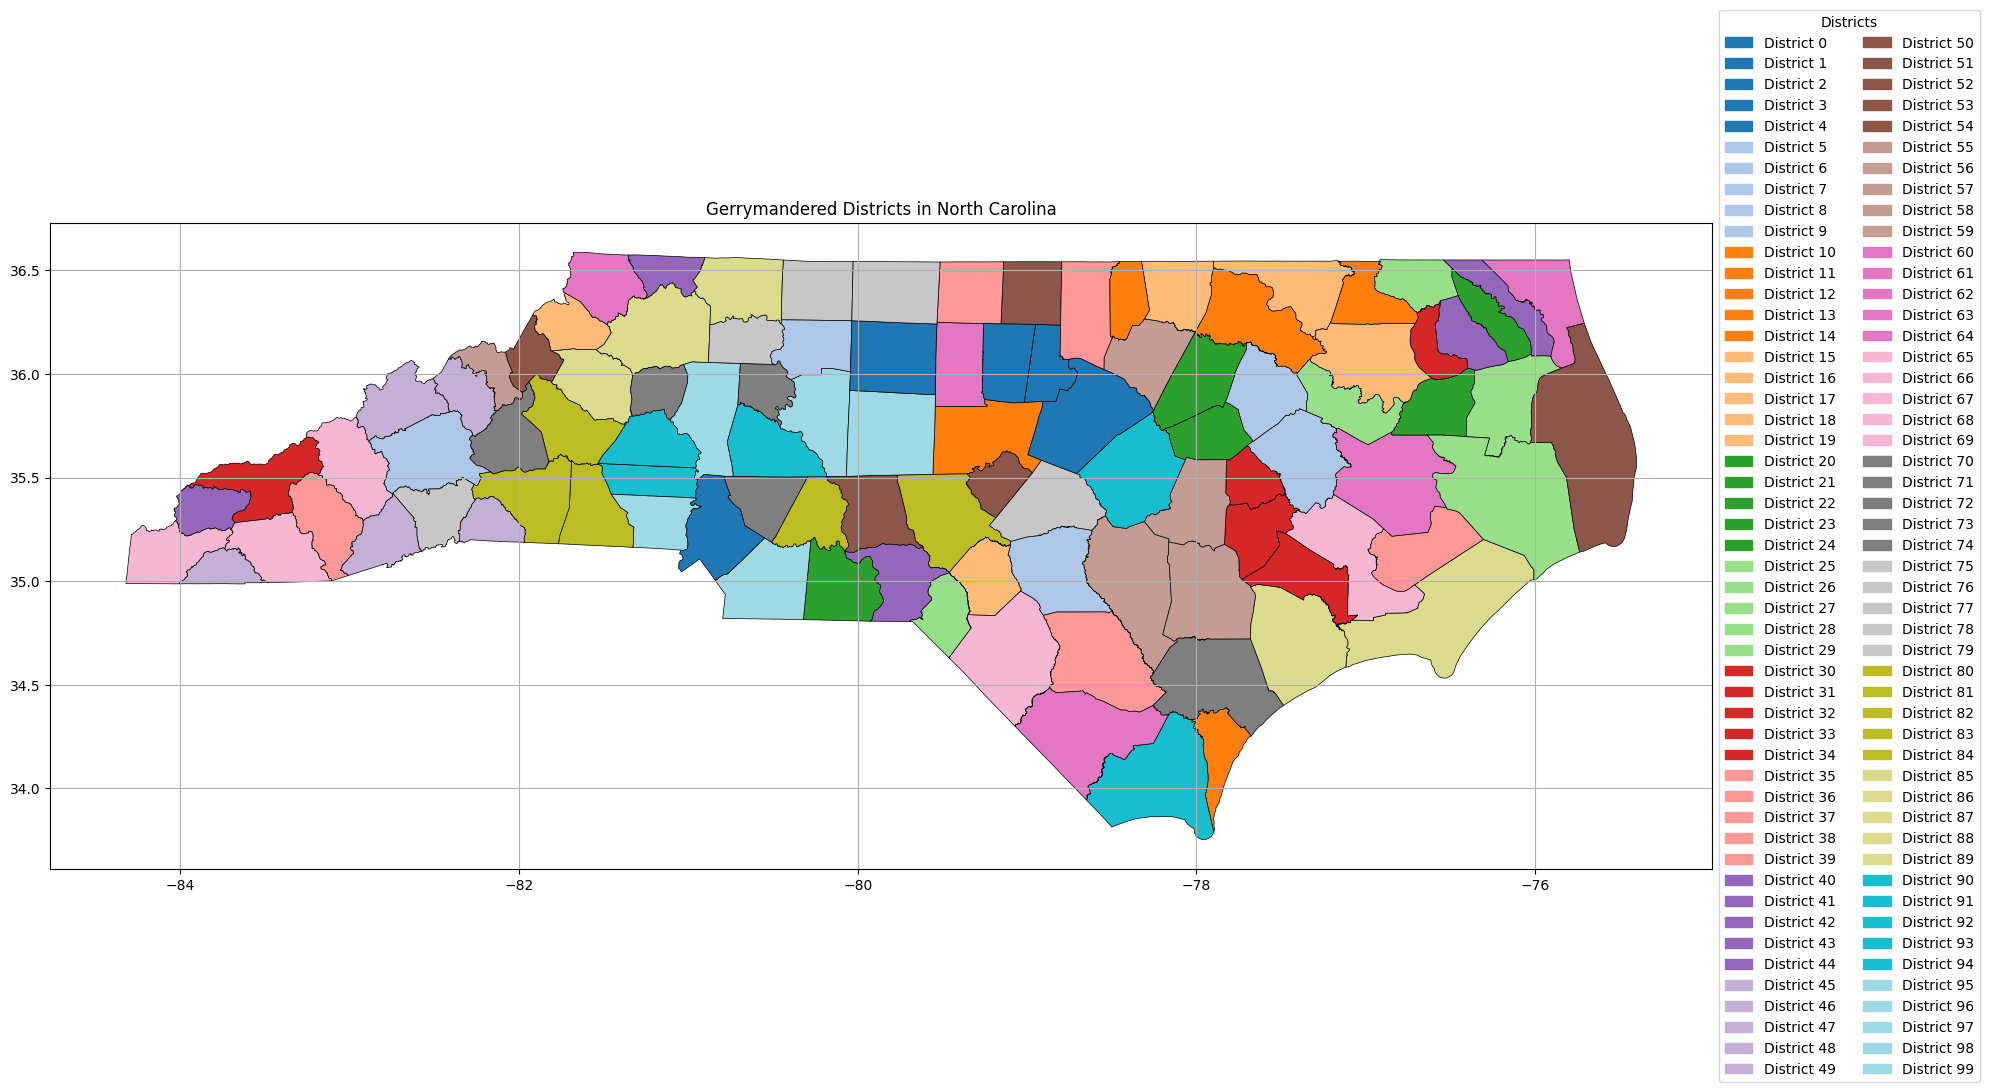

Total number of districts: 100
Number of districts won by Democrats: 75
Number of districts won by Republicans: 25


In [147]:
# Generate a color map with enough distinct colors
colors = plt.cm.tab20(np.linspace(0, 1, n_districts))
color_map = ListedColormap(colors)

# Plot the map
fig, ax = plt.subplots(figsize=(20, 10))
north_carolina.plot(column='new_district', 
                    cmap=color_map, 
                    edgecolor='black', 
                    linewidth=0.5, 
                    ax=ax)

# Create a custom legend
legend_patches = []
for i in range(n_districts):
    patch = mpatches.Patch(color=colors[i], label=f'District {i}')
    legend_patches.append(patch)

# Add the legend to the plot
plt.legend(handles=legend_patches, loc='center left', bbox_to_anchor=(1, 0.5), 
           title='Districts', ncol=2)  # Adjust ncol as needed

plt.title('Gerrymandered Districts in North Carolina')
plt.grid('on')
plt.tight_layout()
plt.show()

# Print out the total number of districts and red wins
print(f"Total number of districts: {n_districts}")
print(f"Number of districts won by Democrats: {Democrat_wins}")
print(f"Number of districts won by Republicans: {n_districts - Democrat_wins}")

## Approach #2

**Explaination:** visualize every 10th district to keep color mapping manageable

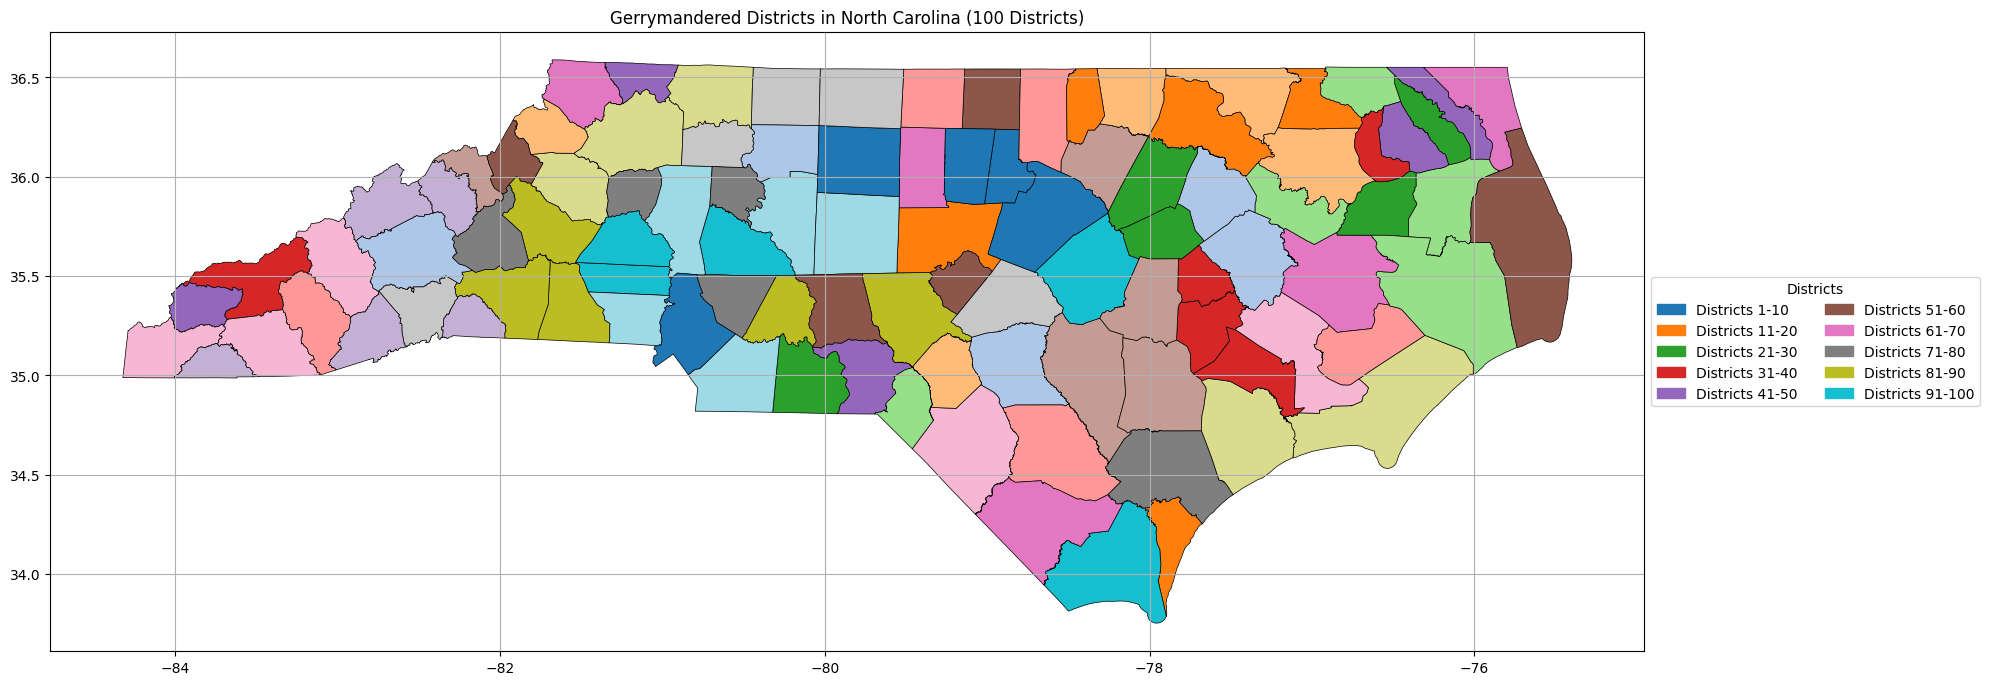

Total number of districts: 100
Number of districts won by Democrats: 75
Number of districts won by Republicans: 25


In [148]:
# Generate a color map with enough distinct colors
colors = plt.cm.tab20(np.linspace(0, 1, n_districts))
color_map = ListedColormap(colors)

# Plot the map
fig, ax = plt.subplots(figsize=(20, 10))
north_carolina.plot(column='new_district', 
                    cmap=color_map, 
                    edgecolor='black', 
                    linewidth=0.5, 
                    ax=ax)

# Create a custom legend (for 100 districts, we'll show only every 10th district to keep it manageable)
legend_patches = []
for i in range(0, n_districts, 10):
    patch = mpatches.Patch(color=colors[i], label=f'Districts {i+1}-{i+10}')
    legend_patches.append(patch)

# Add the legend to the plot
plt.legend(handles=legend_patches, loc='center left', bbox_to_anchor=(1, 0.5), 
           title='Districts', ncol=2)

plt.title('Gerrymandered Districts in North Carolina (100 Districts)')
plt.grid('on')
plt.tight_layout()
plt.show()

# Print out the results
# Democrat_wins = sum(new_north_carolina['REPUBLICAN'] > new_north_carolina['DEMOCRAT']) # this might have to be looked into
print(f"Total number of districts: {n_districts}")
print(f"Number of districts won by Democrats: {Democrat_wins}")
print(f"Number of districts won by Republicans: {n_districts - Democrat_wins}")

## Approach #3

**Explaination:** 

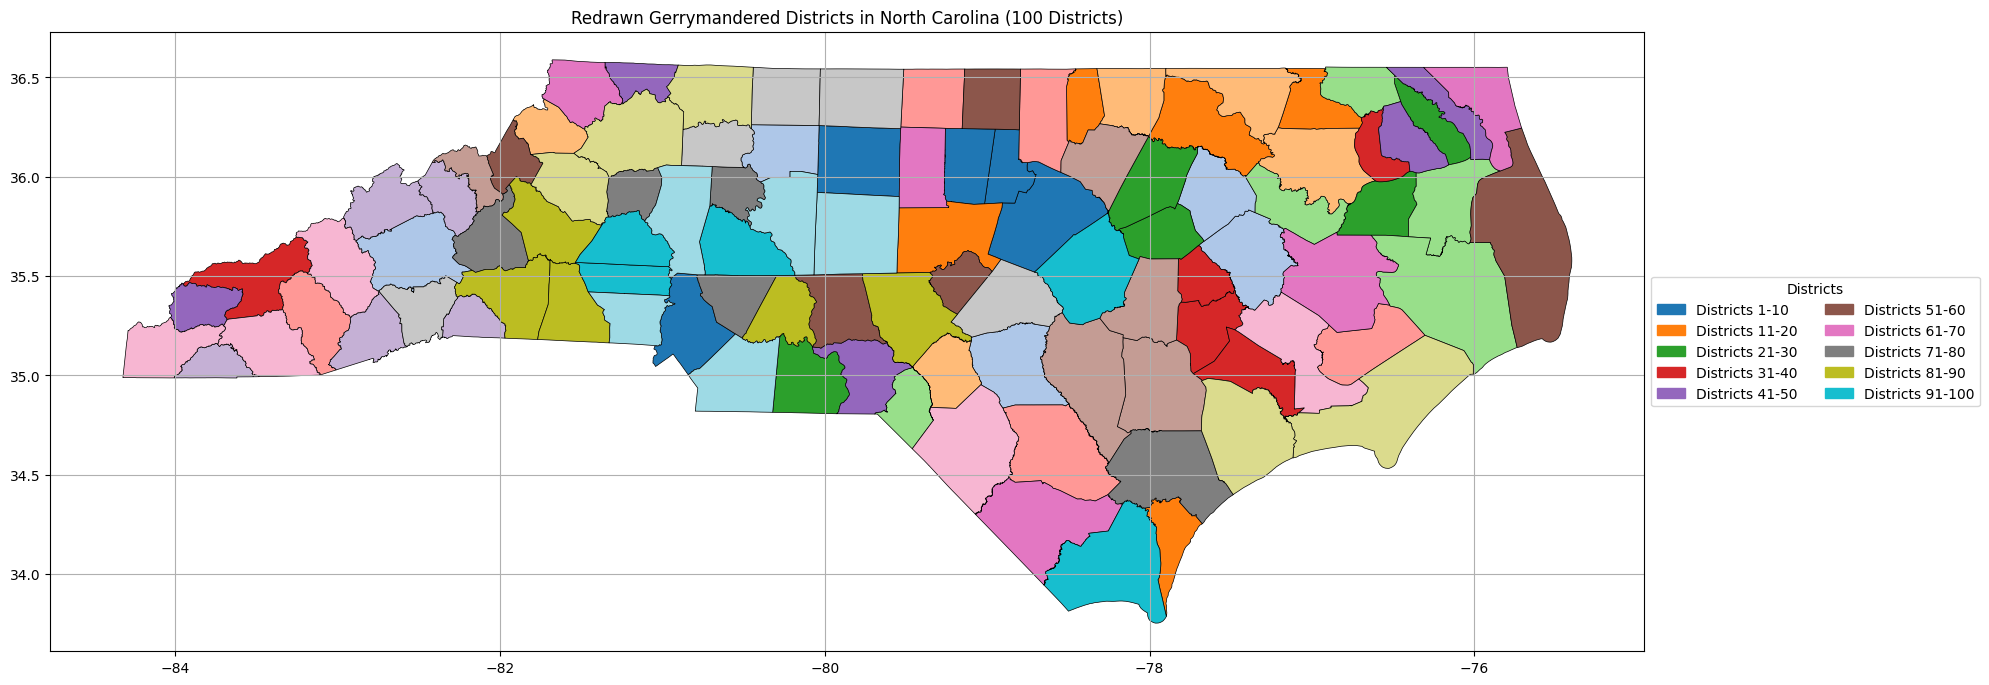

Total number of districts: 100
Number of districts won by Democrats: 75
Number of districts won by Republicans: 25


In [149]:
# Redraw the districts
new_north_carolina = redraw_districts(north_carolina, optimized_districts)

# Calculate total votes for each party in each new district
new_north_carolina['REPUBLICAN'] = 0
new_north_carolina['DEMOCRAT'] = 0
for district in range(n_districts):
    district_areas = north_carolina[optimized_districts == district]
    new_north_carolina.loc[new_north_carolina['district'] == district, 'REPUBLICAN'] = district_areas['REPUBLICAN'].sum()
    new_north_carolina.loc[new_north_carolina['district'] == district, 'DEMOCRAT'] = district_areas['DEMOCRAT'].sum()

# Generate a color map with enough distinct colors
colors = plt.cm.tab20(np.linspace(0, 1, n_districts))
color_map = ListedColormap(colors)

# Plot the new map
fig, ax = plt.subplots(figsize=(20, 10))
new_north_carolina.plot(column='district', 
                        cmap=color_map, 
                        edgecolor='black', 
                        linewidth=0.5, 
                        ax=ax)

# Create a custom legend (showing every 10th district to keep it manageable)
legend_patches = []
for i in range(0, n_districts, 10):
    patch = mpatches.Patch(color=colors[i], label=f'Districts {i+1}-{i+10}')
    legend_patches.append(patch)


plt.legend(handles=legend_patches, loc='center left', bbox_to_anchor=(1, 0.5), 
           title='Districts', ncol=2)
plt.title('Redrawn Gerrymandered Districts in North Carolina (100 Districts)')
plt.grid('on')
plt.tight_layout()
plt.show()

Democrat_wins = sum(new_north_carolina['REPUBLICAN'] > new_north_carolina['DEMOCRAT'])
print(f"Total number of districts: {n_districts}")
print(f"Number of districts won by Democrats: {Democrat_wins}")
print(f"Number of districts won by Republicans: {n_districts - Democrat_wins}")

---------

In [122]:
# Record the end time
end_time = time.time()
print("Notebook execution ended at:", time.strftime("%Y-%m-%d %H:%M:%S", time.localtime(end_time)))

# Calculate the duration
duration = end_time - start_time

# Convert duration to hours, minutes, and seconds
hours, rem = divmod(duration, 3600)
minutes, seconds = divmod(rem, 60)
print(f"Total runtime: {int(hours):02}:{int(minutes):02}:{int(seconds):02}")

Notebook execution ended at: 2024-07-15 11:59:40
Total runtime: 00:03:05


-----------
-----------
### Further project ideas...
Further Project ideas, inspired buy this [youtube video]("https://www.youtube.com/watch?v=ql3Kz8ZjhRg&t=154s").
- Applying Demographic data [Race, Age, Sex, etc..] to apply gerrymandering districting. 
- Possible Dataset retrieval [link]("https://www.nconemap.gov/documents/3e7321d33a0c4aee9d0bf6a22e9bd79f/explore")